In [122]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
import seaborn as sns

In [215]:
pd.__version__

u'0.18.0'

In [152]:
tree = et.parse("../data/AviationData.xml")

In [28]:
root = tree.getroot()
#check the number of child element
len(root[0])

77257

In [244]:
#test
root[0][1000].attrib

{'AccidentNumber': 'ERA15CA086',
 'AirCarrier': '',
 'AircraftCategory': 'Airplane',
 'AircraftDamage': 'Substantial',
 'AirportCode': '2A5',
 'AirportName': 'CAUSEY',
 'AmateurBuilt': 'No',
 'BroadPhaseOfFlight': 'LANDING',
 'Country': 'United States',
 'EngineType': 'Reciprocating',
 'EventDate': '12/27/2014',
 'EventId': '20141230X10247',
 'FARDescription': 'Part 91: General Aviation',
 'InjurySeverity': 'Non-Fatal',
 'InvestigationType': 'Accident',
 'Latitude': '35.911667',
 'Location': 'Liberty, NC',
 'Longitude': '-79.617778',
 'Make': 'CESSNA',
 'Model': '310N',
 'NumberOfEngines': '2',
 'PublicationDate': '06/09/2015',
 'PurposeOfFlight': 'Personal',
 'RegistrationNumber': 'N177JD',
 'ReportStatus': 'Probable Cause',
 'Schedule': '',
 'TotalFatalInjuries': '',
 'TotalMinorInjuries': '',
 'TotalSeriousInjuries': '',
 'TotalUninjured': '2',
 'WeatherCondition': 'VMC'}

In [109]:
#create a dataframe
events_list = [i.attrib for i in root[0]]
df_events = pd.DataFrame(events_list)
df_events.head()

,AccidentNumber,AirCarrier,AircraftCategory,AircraftDamage,AirportCode,AirportName,AmateurBuilt,BroadPhaseOfFlight,Country,EngineType,...,PublicationDate,PurposeOfFlight,RegistrationNumber,ReportStatus,Schedule,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured,WeatherCondition
0,GAA15CA244,,,,,,,,United States,,...,,,N786AB,Preliminary,,,,,,
1,CEN15LA392,,Airplane,Substantial,IWS,WEST HOUSTON,No,LANDING,United States,,...,09/04/2015,Instructional,N452CS,Preliminary,,,,,2,VMC
2,GAA15CA246,,,,,,,,United States,,...,,,N112RP,Preliminary,,,,,,
3,GAA15CA243,,,,,,,,United States,,...,,,N8404X,Preliminary,,,,,,
4,GAA15CA242,,,,,,,,United States,,...,,,N5255G,Preliminary,,,,,,


## Clean-up

The dataframe has one major problem: empty cells from XML are stored as '' instead of null. 

In [ ]:
df_events['EventDate'] = pd.to_datetime(df_events['EventDate'])
df_events['PublicationDate'] = pd.to_datetime(df_events['PublicationDate'])

In [130]:
df_events['AirCarrier'].iloc[0]

''

In [255]:
df_events['AircraftDamage'].unique()

array(['', 'Substantial', 'Minor', 'Destroyed'], dtype=object)

In [213]:
#replace empty string with nan and calculate missing value
df_e = df_events.replace(r'^\s*$',np.nan, regex=True)
(len(df_e.index)-df_e.count())/len(df_e.index)*100

AccidentNumber           0.000000
AirCarrier              95.058053
AircraftCategory        78.616824
AircraftDamage           3.085805
AirportCode             43.724193
AirportName             38.735649
AmateurBuilt             0.846525
BroadPhaseOfFlight       8.060111
Country                  0.660134
EngineType               4.153669
EventDate                0.003883
EventId                  0.000000
FARDescription          78.429139
InjurySeverity           0.137204
InvestigationType        0.000000
Latitude                69.244211
Location                 0.104845
Longitude               69.255860
Make                     0.112611
Model                    0.148854
NumberOfEngines          5.075268
PublicationDate         17.070298
PurposeOfFlight          4.657183
RegistrationNumber       3.567314
ReportStatus             0.000000
Schedule                85.271238
TotalFatalInjuries      27.785185
TotalMinorInjuries      29.154640
TotalSeriousInjuries    30.434783
TotalUninjured

From the missing value table above, it is clear that not every variables are usable for meaningful analysis.
The subsequent dataset will be a subset of the original dataset based on 'Make' variable as it has very few missing values.

Assumption: No value in injuries variables doesn't always mean that it is zero as it can also means that it is unknown.

In [216]:
#code to transform no value = 0
#df_e[['TotalFatalInjuries','TotalMinorInjuries','TotalSeriousInjuries','TotalUninjured']] = df_e[['TotalFatalInjuries','TotalMinorInjuries','TotalSeriousInjuries','TotalUninjured']].fillna(0)
df_e[['TotalFatalInjuries','TotalMinorInjuries','TotalSeriousInjuries','TotalUninjured']] = df_e[['TotalFatalInjuries','TotalMinorInjuries','TotalSeriousInjuries','TotalUninjured']].apply(pd.to_numeric)

In [245]:
df_e['TotalPerson'] = df_e['TotalFatalInjuries'] + df_e['TotalSeriousInjuries'] + df_e['TotalMinorInjuries'] + df_e['TotalUninjured'] 

In [246]:
df_e['PctInjured'] = (df_e['TotalSeriousInjuries'] + df_e['TotalMinorInjuries']) / df_e['TotalPerson']
df_e['PctDeath'] = df_e['TotalFatalInjuries'] / df_e['TotalPerson']

In [226]:
print "Number of accidents in the dataset: " + str(len(df_e.index))
print "Date range: " + str(df_e['EventDate'].min()) + " to " + str(df_e['EventDate'].max())
df_e[['TotalFatalInjuries','TotalMinorInjuries','TotalSeriousInjuries','TotalUninjured']].describe()

Number of accidents in the dataset: 77257
Date range: 1948-10-24 00:00:00 to 2015-09-01 00:00:00


,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured
count,55791.000000,54733.000000,53744.000000,65862.000000
mean,0.788962,0.492555,0.309895,5.716817
std,6.087442,2.779814,1.368488,29.052413
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,2.000000
max,349.000000,380.000000,111.000000,699.000000


In [254]:
df_e1 = df_e[['PctInjured','PctDeath','TotalPerson']]
df_e1[(df_e1.TotalPerson >50)].describe()

,PctInjured,PctDeath,TotalPerson
count,1033.000000,1033.000000,1033.000000
mean,0.031878,0.036979,149.686350
std,0.097279,0.176222,88.348425
min,0.000000,0.000000,51.000000
25%,0.000000,0.000000,87.000000
50%,0.000000,0.000000,125.000000
75%,0.016529,0.000000,185.000000
max,1.000000,1.000000,528.000000


### Initial Impression
1. The dataset covers 6 decades of accidents, from 1948 to 2015
2. Overall, a very large number of accidents don't result in fatalities or injuries
3. However, once it does, it's ugly.

In [235]:
df_f = df_e[['TotalFatalInjuries','TotalMinorInjuries','TotalSeriousInjuries','TotalUninjured']]

In [243]:
df_e[(df_e.TotalFatalInjuries == 11)]

,AccidentNumber,AirCarrier,AircraftCategory,AircraftDamage,AirportCode,AirportName,AmateurBuilt,BroadPhaseOfFlight,Country,EngineType,...,PublicationDate,PurposeOfFlight,RegistrationNumber,ReportStatus,Schedule,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured,WeatherCondition
1756,CEN14RA340,NaN,Airplane,Destroyed,NaN,NaN,NaN,TAKEOFF,Poland,Reciprocating,...,2014-08-25,NaN,N11WB,Foreign,NaN,11.0,NaN,1.0,NaN,NaN
6340,WPR11MA454,NaN,Airplane,Substantial,KRTS,Reno/Stead Airport,No,MANEUVERING,United States,Reciprocating,...,2014-03-17,Air Race/Show,N79111,Probable Cause,NaN,11.0,NaN,66.0,NaN,VMC
8823,DCA10WA070,NaN,NaN,Destroyed,NaN,NaN,NaN,NaN,Congo,NaN,...,2011-10-28,NaN,NaN,Foreign,NSCH,11.0,NaN,NaN,NaN,NaN
11995,NYC08RA286,NaN,NaN,Destroyed,NaN,NaN,No,NaN,Guatemala,NaN,...,2008-09-14,NaN,NaN,Foreign,NSCH,11.0,NaN,3.0,NaN,VMC
12630,NYC08RA197,NaN,NaN,Destroyed,NaN,NaN,No,NaN,Panama,NaN,...,2008-06-10,Public Aircraft - Federal,NaN,Foreign,NaN,11.0,NaN,1.0,NaN,VMC
13125,NYC08WA114,NaN,NaN,Destroyed,NaN,NaN,No,NaN,Chile,NaN,...,2008-03-19,Instructional,NaN,Foreign,NaN,11.0,NaN,20.0,NaN,VMC
13195,DCA08WA069,NaN,NaN,NaN,NaN,NaN,No,NaN,Japan,NaN,...,2008-07-23,NaN,NaN,Foreign,SCHD,11.0,NaN,1.0,61.0,NaN
27657,MIA01WA015B,NaN,NaN,Destroyed,NaN,NaN,No,NaN,Argentina,Unknown,...,2000-11-01,Personal,NaN,Foreign,UNK,11.0,0.0,0.0,0.0,VMC
27658,MIA01WA015A,NaN,NaN,Destroyed,NaN,NaN,No,NaN,Argentina,Unknown,...,2000-11-01,Personal,NaN,Foreign,UNK,11.0,0.0,0.0,0.0,VMC
28209,DCA00MA080B,NaN,NaN,Destroyed,NaN,NaN,No,CRUISE,United States,Unknown,...,2003-01-30,Instructional,N2225G,Probable Cause,NaN,11.0,0.0,0.0,0.0,VMC


## Initial Exploration

Question: what is the most dangerous phase of flight, represented by number of fatalities?

In [67]:
#check phase and fatalinjuries
df_flight_phase = df_events[['BroadPhaseOfFlight','TotalFatalInjuries']].groupby('BroadPhaseOfFlight',as_index=False).count()
df_flight_phase

,BroadPhaseOfFlight,TotalFatalInjuries
0,,6227
1,APPROACH,7510
2,CLIMB,2225
3,CRUISE,10597
4,DESCENT,2152
5,GO-AROUND,1570
6,LANDING,18553
7,MANEUVERING,9499
8,OTHER,147
9,STANDING,1163


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

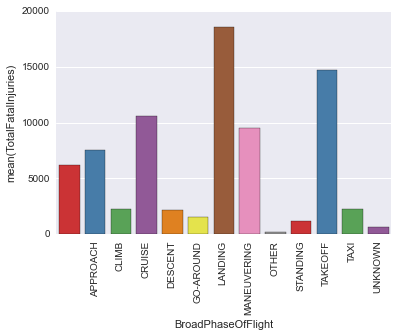

In [99]:
x = df_flight_phase['BroadPhaseOfFlight']
y = df_flight_phase['TotalFatalInjuries']
#lt.figure(figsize=(50,50))
sns.barplot(x,y,palette="Set1")
plt.xticks(rotation=90) 

In [100]:
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': 'white',
 'axes.facecolor': '#EAEAF2',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.linewidth': 0.0,
 'figure.facecolor': (1, 1, 1, 0),
 'font.family': [u'sans-serif'],
 'font.sans-serif': [u'Arial',
  u'Liberation Sans',
  u'Bitstream Vera Sans',
  u'sans-serif'],
 'grid.color': 'white',
 'grid.linestyle': u'-',
 'image.cmap': u'Greys',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': u'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': u'out',
 'xtick.major.size': 0.0,
 'xtick.minor.size': 0.0,
 'ytick.color': '.15',
 'ytick.direction': u'out',
 'ytick.major.size': 0.0,
 'ytick.minor.size': 0.0}